In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Graph neural networks for spatially-aware node regression

**Author:** Ji Won Park (@jiwoncpark)

**Last updated:** 2/27/2020

**Created:** 2/27/2020

We'll be putting an edge from all the nodes of the graph to the central node (the "zeroth node") as well as an undirected edge between every pair of non-central ("neighbor") nodes that are within distance 0.5 of one another.

There are three node features (I'll refer to them as features 0, 1, and 2), each generated from a standard normal distribution. The zeroth node has the features all zeroed out.

We have three labels.
For the "isotropic" case, they are
- sum of feature 1 across all the neighbor
- mean of feature 2 across all the neighbors
- number of neighbors

For the "anisotropic" case, they are
- weighted sum of neighbors, where the weights are inverse L2 norm of features 0 and 1
- same as above except only including neighbors with feature 2 > 0
- number of neighbors with the above cut

Text(0, 0.5, 'Count')

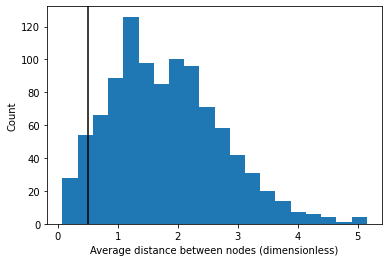

In [2]:
delta_xy = np.random.randn(1000, 2) - np.random.randn(1000, 2)
dist = np.linalg.norm(delta_xy, axis=1)
plt.hist(dist, bins=20)
plt.axvline(0.5, color='k', label='closeness edge criterion')
plt.xlabel('Average distance between nodes (dimensionless)')
plt.ylabel('Count')

## Graph visualization

Let's take a look at what each training input looks like.

In [3]:
# Instantiate the dataset object
from regression_dataset import ToyDataset
train_dataset = ToyDataset(root='.', size=10000, seed=123)

Processing...
Done!


torch.Size([16, 3]) torch.Size([2, 28])


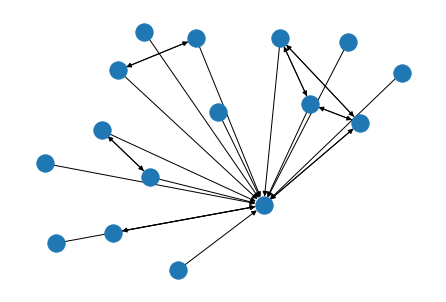

In [4]:
# Use networkx to draw the first training example
from torch_geometric.utils import to_networkx
import networkx as nx
sample_data = train_dataset[1]
sample_networkx = to_networkx(sample_data)
nx.draw(sample_networkx)
print(sample_data.x.shape, sample_data.edge_index.shape)

## Dataloaders

In [5]:
from torch_geometric.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=0, drop_last=True)
val_dataset = ToyDataset(root='.', size=100, seed=456)
val_dataset.mean_std = train_dataset.mean_std
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=0, drop_last=True)

Processing...
Done!


## Model

Our task is a node regression, i.e. regressing on the three target values for the central node in each graph. We can print out the shape of the output, which should be `[batch_size, 3]`.

In [6]:
import gnn

In [ ]:
model = gnn.GATNet(in_channels=3, out_channels=3, hidden_channels=16)
for batch in train_loader:
    print(batch.x.shape, batch.edge_index.shape, batch.y.shape)
    out = model(batch)
    print(out.shape)
    break

## Training various models on isotropically generated labels

We'll train both isotropic and anisotropic architectures on our labels, which are generated by weighting all neighboring nodes equally. Regular GCN-type network and GraphSage network are isotropic. GAT (graph attention network) is anisotropic. We expect the isotropic networks to do no worse than anisotropic ones.

In [7]:
import torch
import torch.nn as nn
from torch import optim

def train_model(model_name):
    mean, std = train_dataset.mean_std
    results = {}
    model = getattr(gnn, model_name)(in_channels=3, out_channels=3, hidden_channels=32)
    device = torch.device('cuda')
    mse_loss = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=1.e-4, weight_decay=1e-5)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, cooldown=0, min_lr=1e-5, verbose=True)
    def train_single_epoch(epoch_i):
        total_loss = 0.0
        n_iter = 0
        for batch_i, batch in enumerate(train_loader):
            batch = batch.to(device)
            out = model(batch)
            loss = mse_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += (loss.detach().item() - total_loss)/(1 + n_iter)
            n_iter += 1
        return total_loss
    train_loss = []
    model = model.to(device)
    model.train()
    for epoch_i in range(300):
        train_loss_i = train_single_epoch(epoch_i)
        lr_scheduler.step(train_loss_i)
        train_loss.append(train_loss_i)
        #if epoch_i %10 == 0:
            #print(train_loss_i)
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            val_loss = mse_loss(out, batch.y).item()
            out_val = (out.cpu()*std + mean).numpy()
            y_val = (batch.y.cpu()*std + mean).numpy()
            break
    results = {'model': model, 'out_val': out_val, 'y_val': y_val, 'train_loss': train_loss, 'val_loss': val_loss}
    return results

In [8]:
experiment = {}
for arch in ['GCNNet', 'GATNet', 'SageNet']:
    experiment[arch] = train_model(arch)

Epoch    42: reducing learning rate of group 0 to 5.0000e-05.
Epoch    63: reducing learning rate of group 0 to 2.5000e-05.
Epoch   119: reducing learning rate of group 0 to 1.2500e-05.
Epoch   152: reducing learning rate of group 0 to 1.0000e-05.
Epoch    55: reducing learning rate of group 0 to 5.0000e-05.
Epoch    76: reducing learning rate of group 0 to 2.5000e-05.
Epoch   148: reducing learning rate of group 0 to 1.2500e-05.
Epoch   204: reducing learning rate of group 0 to 1.0000e-05.
Epoch    89: reducing learning rate of group 0 to 5.0000e-05.
Epoch   110: reducing learning rate of group 0 to 2.5000e-05.


In [ ]:
experiment.keys()

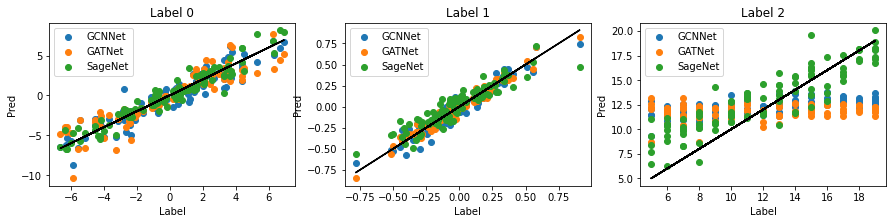

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for target_i in range(3):
    for i, (k, v) in enumerate(experiment.items()):
        axes[target_i].scatter(v['y_val'][:, target_i], v['out_val'][:, target_i], label=k)
    axes[target_i].plot(v['y_val'][:, target_i], v['y_val'][:, target_i], color='k')
    axes[target_i].set_title('Label {:d}'.format(target_i))
    axes[target_i].set_xlabel('Label')
    axes[target_i].set_ylabel('Pred')
    axes[target_i].legend()
fig.savefig('isotropic_labels.png')

Models aren't quite converged yet!

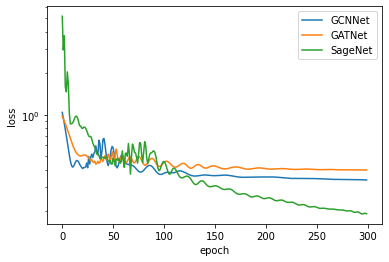

In [17]:
plt.close('all')
for i, (k, v) in enumerate(experiment.items()):
    plt.plot(v['train_loss'], label=k)
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
fig.savefig('isotropic_loss.png')

Let's export the results for later access.

In [11]:
import pickle
with open('isotropic_experiment.pickle', 'wb') as handle:
    pickle.dump(experiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Training various models on anisotropically generated labels

We'll now train on labels generated by excluding some nodes and assigning different weights to diferent nodes. We expect the anisotropic networks to do better than isotropic ones.

In [12]:
from regression_dataset import ToyDataset
train_dataset = ToyDataset(root='.', size=10000, seed=123, anisotropic=True)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=0, drop_last=True)
val_dataset = ToyDataset(root='.', size=100, seed=456, anisotropic=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=0, drop_last=True)

Processing...
Done!
Processing...
Done!


In [13]:
experiment_anisotropic = {}
for arch in ['GCNNet', 'GATNet', 'SageNet']:
    experiment_anisotropic[arch] = train_model(arch)

Epoch   148: reducing learning rate of group 0 to 5.0000e-05.
Epoch   117: reducing learning rate of group 0 to 5.0000e-05.
Epoch   106: reducing learning rate of group 0 to 5.0000e-05.
Epoch   218: reducing learning rate of group 0 to 2.5000e-05.
Epoch   262: reducing learning rate of group 0 to 1.2500e-05.
Epoch   283: reducing learning rate of group 0 to 1.0000e-05.


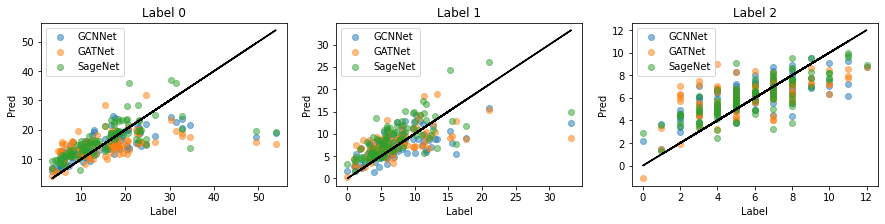

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for target_i in range(3):
    for i, (k, v) in enumerate(experiment_anisotropic.items()):
        axes[target_i].scatter(v['y_val'][:, target_i], v['out_val'][:, target_i], label=k, alpha=0.5)
    axes[target_i].plot(v['y_val'][:, target_i], v['y_val'][:, target_i], color='k')
    axes[target_i].set_title('Label {:d}'.format(target_i))
    axes[target_i].set_xlabel('Label')
    axes[target_i].set_ylabel('Pred')
    axes[target_i].legend()
fig.savefig('anisotropic_labels.png')

Again, we see that we should train for longer but can reasonable results at 300 epochs.

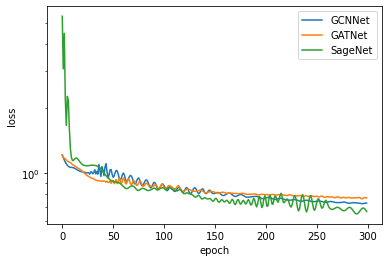

In [18]:
plt.close('all')
for i, (k, v) in enumerate(experiment_anisotropic.items()):
    plt.plot(v['train_loss'], label=k)
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
fig.savefig('anisotropic_loss.png')

In [16]:
with open('anisotropic_experiment.pickle', 'wb') as handle:
    pickle.dump(experiment_anisotropic, handle, protocol=pickle.HIGHEST_PROTOCOL)